# Titanic Survival Classification

In [30]:
library(readr)
library(corrplot)
library(ggplot2)
library(dplyr) # data man
library(e1071)
library(MASS) # SVM
library(naivebayes) # naive Bayes
library(rpart) # Decision Tree
library(rpart.plot)
library(caret)
library(randomForest)

# Load Data

In [31]:
train <- read_csv("../Titanic/train.csv")
test <- read_csv("../Titanic/test.csv")
gender_submission <- read_csv("../Titanic/gender_submission.csv")

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Survived = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)
Parsed with column specification:
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)
Parsed with column specification:
cols(
  PassengerId = col_double(),
  Survived = col_double()
)


# Data Clean

The training data contains a significant amount of missing information, especially in the age variable, which has numerous missing entries. To address this issue, we replaced these missing entries with the mean age values for both males and females. Additionally, we ensured that the variables were in the correct data type, coercing them into categorical binary variables.

In [32]:
train <- train %>% dplyr::select(-c(Name))
test <- test %>% dplyr::select(-c(Name))

train <- train %>% mutate_if(is.character, as.factor)
test <- test %>% mutate_if(is.character, as.factor)

summary(train)
sum(is.na(train)) # 866
sum(is.na(train$Cabin)) # 687

Cabin_Data <- train[is.na(train$Cabin) == FALSE,] # Cabin analysis

sum(duplicated(train)) # 0 No duplicated -> No repeating rows

colSums(is.na(train))
age_missing <- table(ifelse(is.na(train$Age) == TRUE, "Missing","Not Missing")) # 177 
prop.table(age_missing)

male <- train[train$Sex == "male",5]
tmale <- test[test$Sex == "male",5]
female <- train[train$Sex == "female",5]
tfemale <- test[test$Sex == "female",5]
mean_male <- mean(male$Age,na.rm = TRUE)
mean_malet <- mean(tmale$Age,na.rm = TRUE)
mean_female <- mean(female$Age,na.rm = TRUE)
mean_femalet <- mean(tfemale$Age,na.rm = TRUE)

train$Age <- ifelse(is.na(train$Age) == TRUE & train$Sex == "male",mean_male,train$Age)
train$Age <- ifelse(is.na(train$Age) == TRUE & train$Sex == "female",mean_female,train$Age)
test$Age <- ifelse(is.na(test$Age) == TRUE & test$Sex == "male",mean_malet,test$Age)
test$Age <- ifelse(is.na(test$Age) == TRUE & test$Sex == "female",mean_femalet,test$Age)

sum(is.na(train$Age))

class(train$Survived)
train$Survived <- as.factor(train$Survived)


  PassengerId       Survived          Pclass          Sex           Age       
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000   female:314   Min.   : 0.42  
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000   male  :577   1st Qu.:20.12  
 Median :446.0   Median :0.0000   Median :3.000                Median :28.00  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309                Mean   :29.70  
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000                3rd Qu.:38.00  
 Max.   :891.0   Max.   :1.0000   Max.   :3.000                Max.   :80.00  
                                                               NA's   :177    
     SibSp           Parch             Ticket         Fare       
 Min.   :0.000   Min.   :0.0000   1601    :  7   Min.   :  0.00  
 1st Qu.:0.000   1st Qu.:0.0000   347082  :  7   1st Qu.:  7.91  
 Median :0.000   Median :0.0000   CA. 2343:  7   Median : 14.45  
 Mean   :0.523   Mean   :0.3816   3101295 :  6   Mean   : 32.20  
 3rd Qu.:1.000   3rd Qu.:0.0000   3470

[1] 866

[1] 687

[1] 0

PassengerId    Survived      Pclass         Sex         Age       SibSp 
          0           0           0           0         177           0 
      Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0         687           2


    Missing Not Missing 
  0.1986532   0.8013468 

Warning message:
"Unknown or uninitialised column: 'Age'."Warning message in mean.default(tmale$Age, na.rm = TRUE):
"argument is not numeric or logical: returning NA"Warning message:
"Unknown or uninitialised column: 'Age'."Warning message in mean.default(tfemale$Age, na.rm = TRUE):
"argument is not numeric or logical: returning NA"

[1] 0

[1] "numeric"

# EDA

* Table: The table reveals that 62% of the people did not survive.
* 
Correlation Matri:    + 

The correlation matrix shows that the 'Age' vs 'Fare,' the two double numeric variables, are practically independent (0.0    + 9).
The correlation matrix indicates that 'Parch' vs 'SibSp,' the two double numeric variables, are somewhat positively correlated (0.* 41).
Gr:h    + ics:

Overall, people sitting in the third class of the Titanic had a higher survival rate compared to the other two c    + lasses.
Furthermore, it is evident that younger people in the age range of 0 to 10 years (kids) had a higher survival rate compared to those in their 40s or beyond.


  0   1 
549 342 

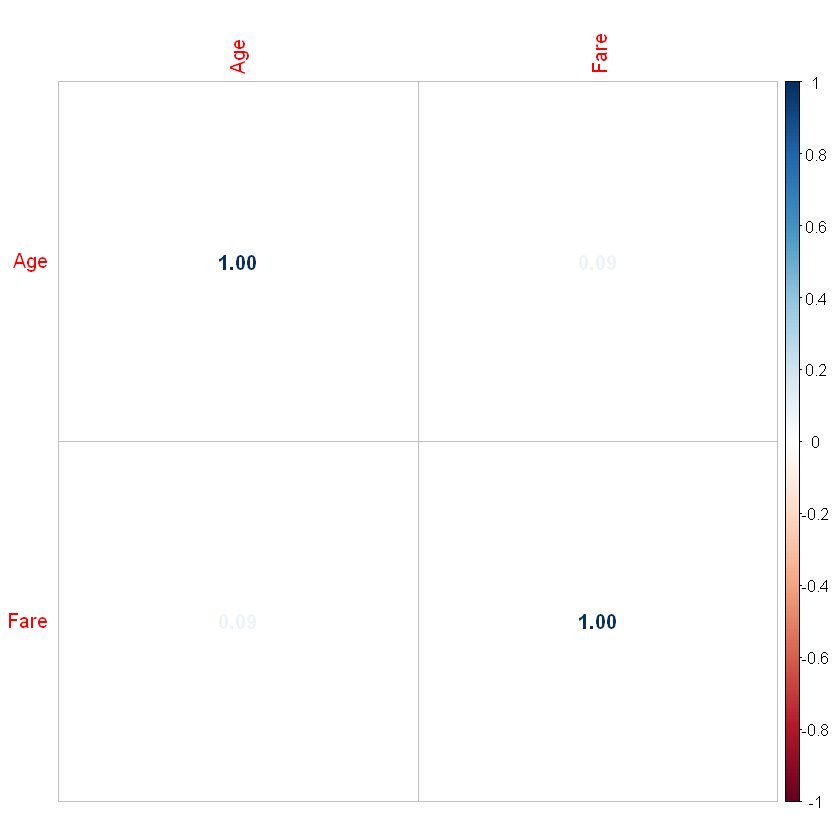

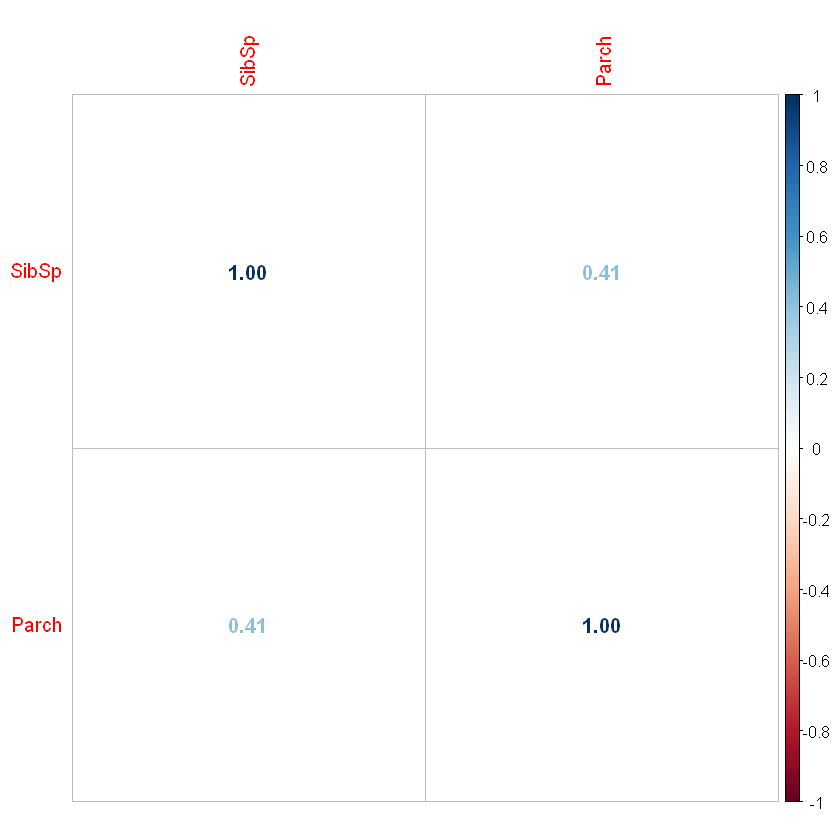

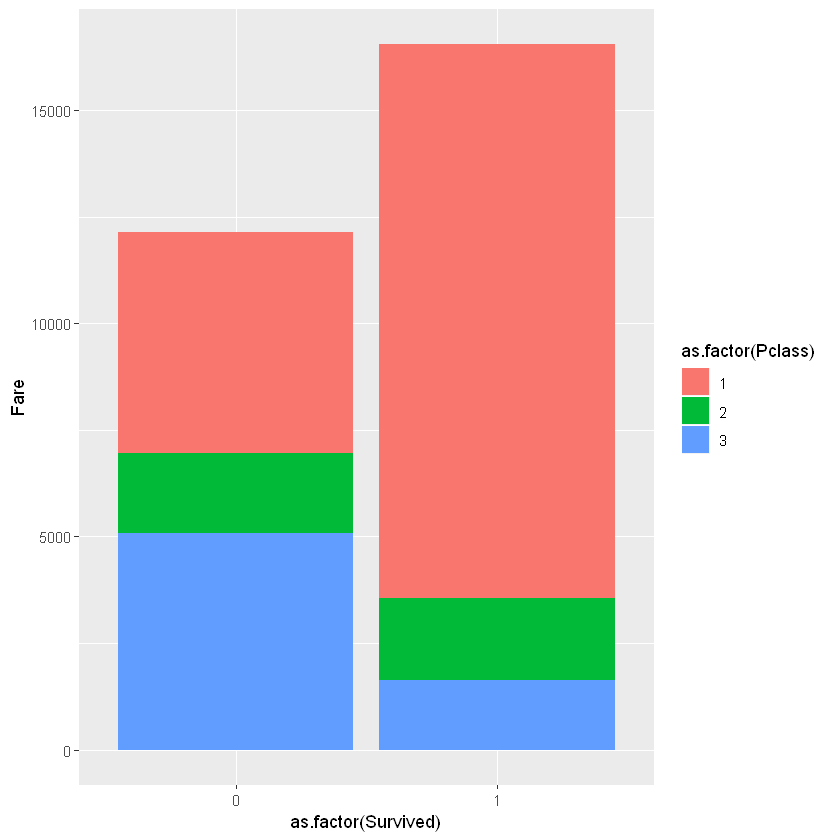

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


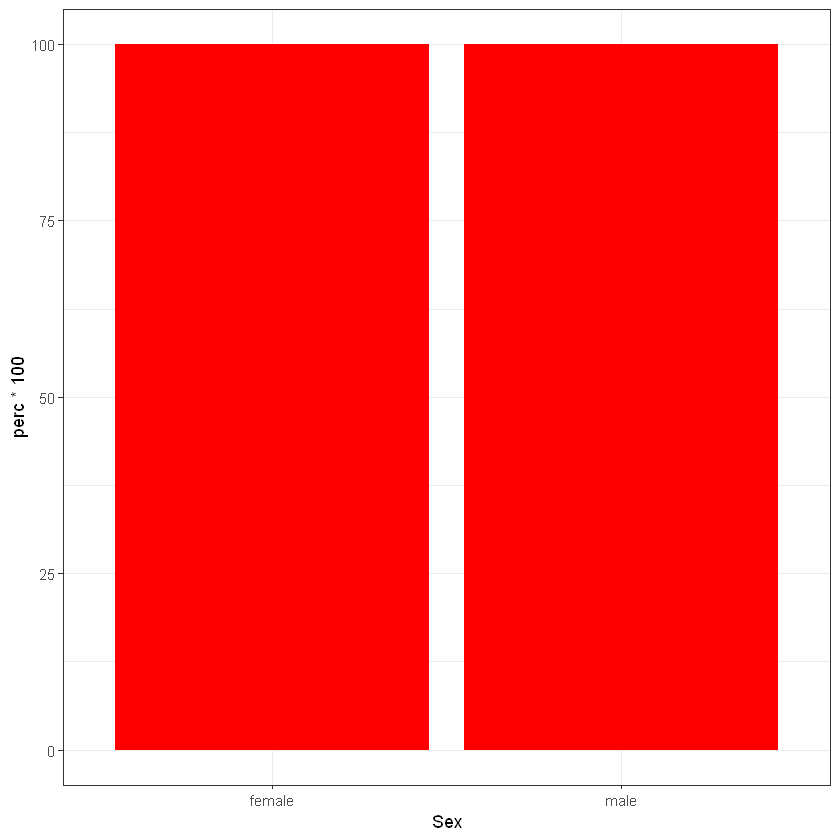

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


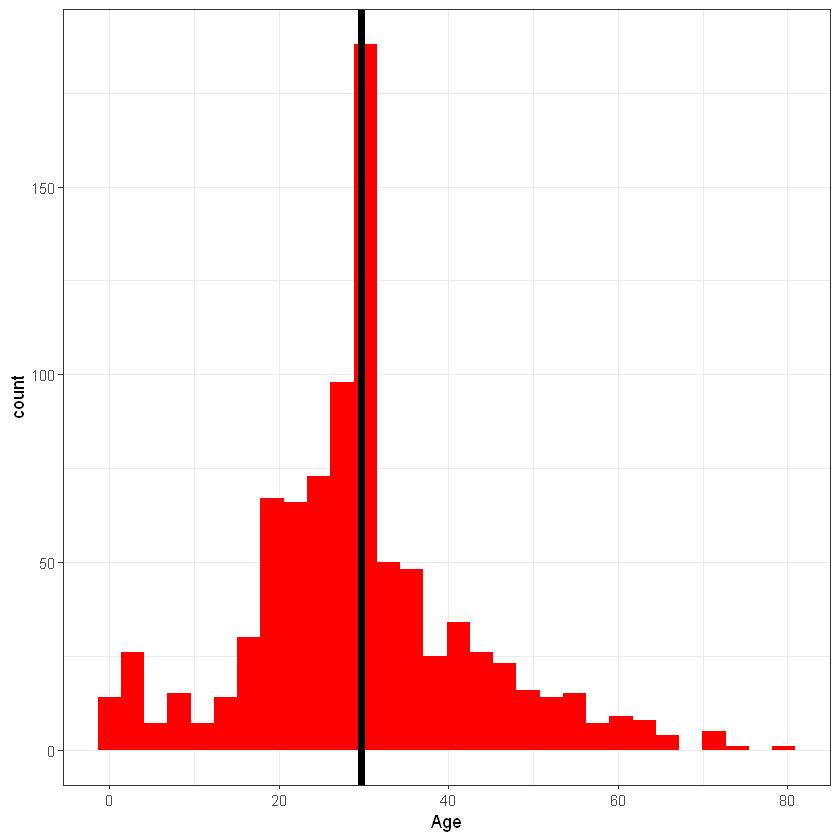

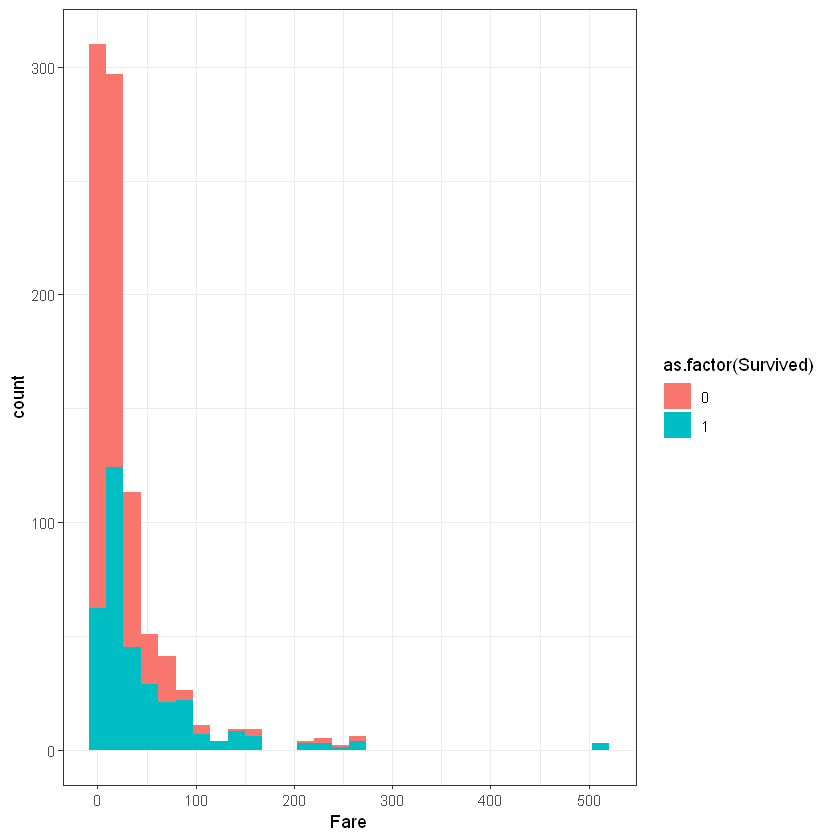

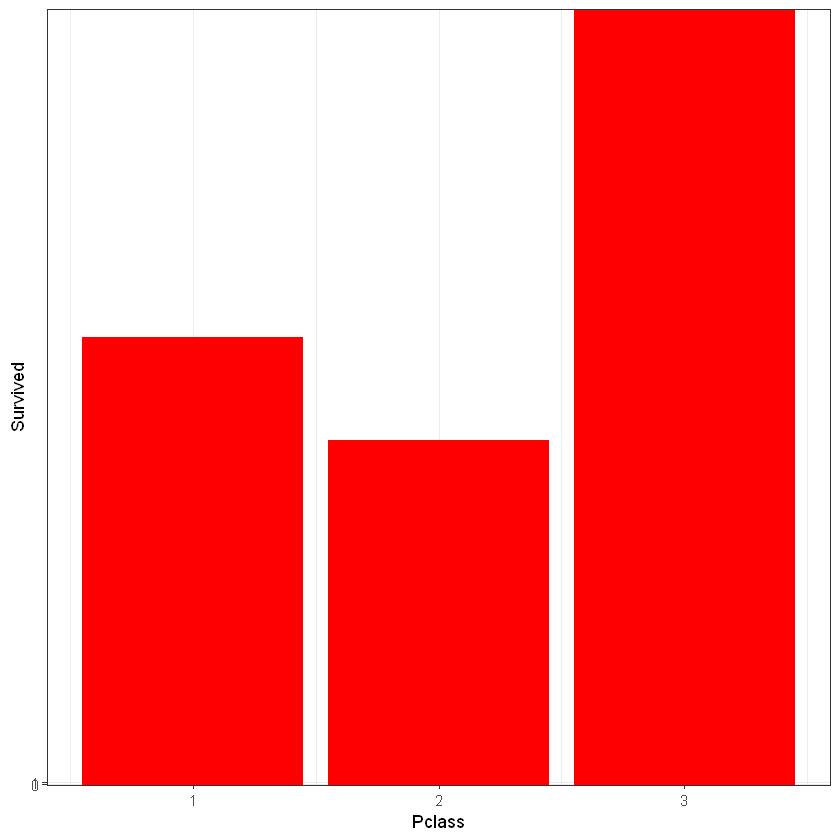

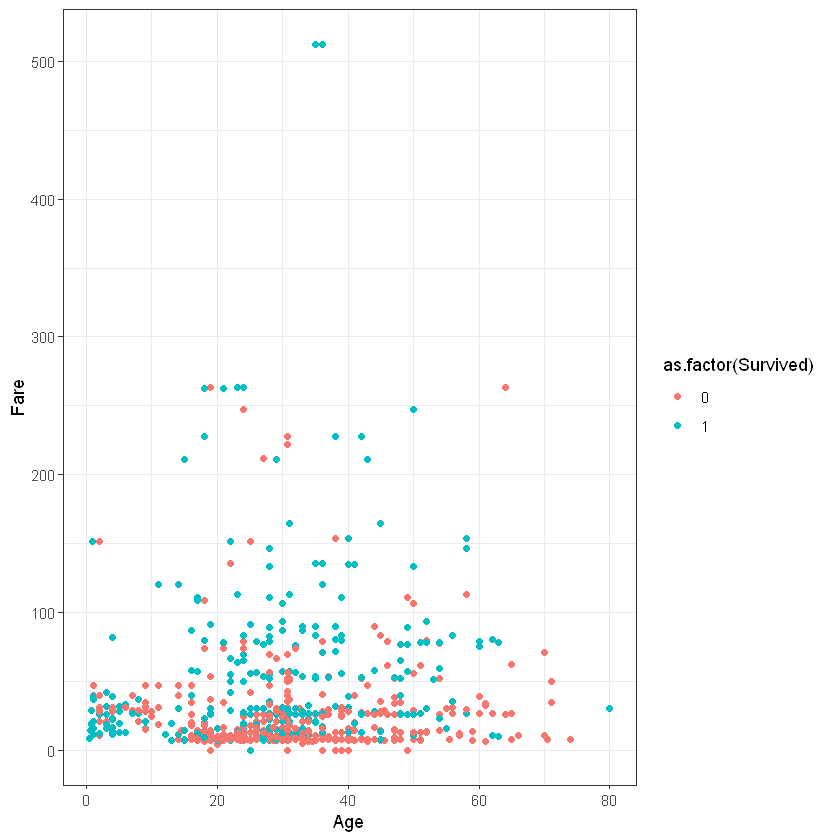

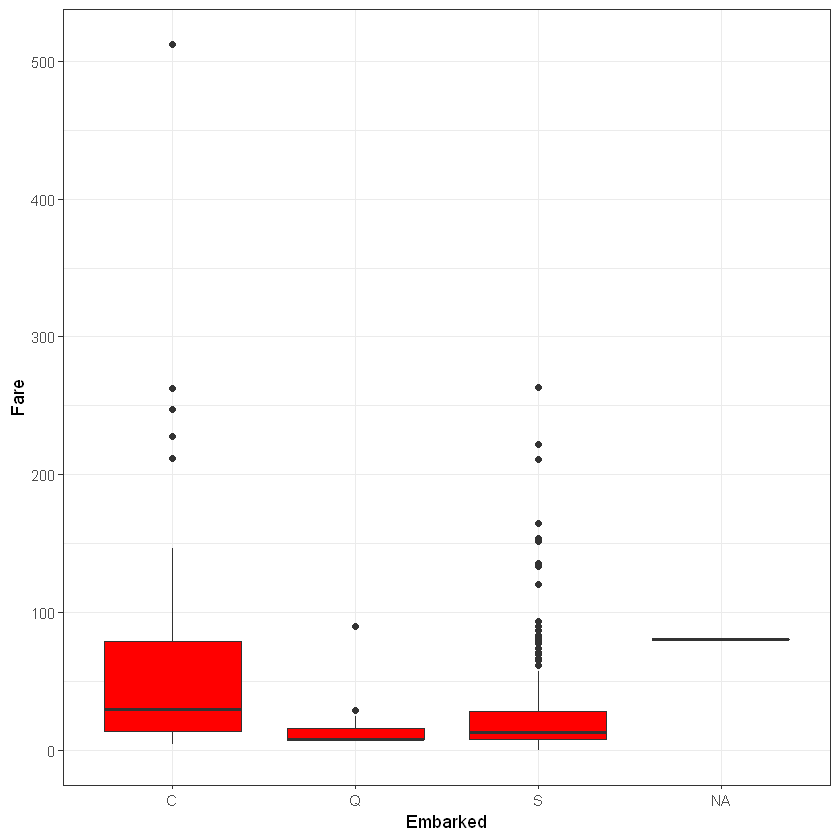

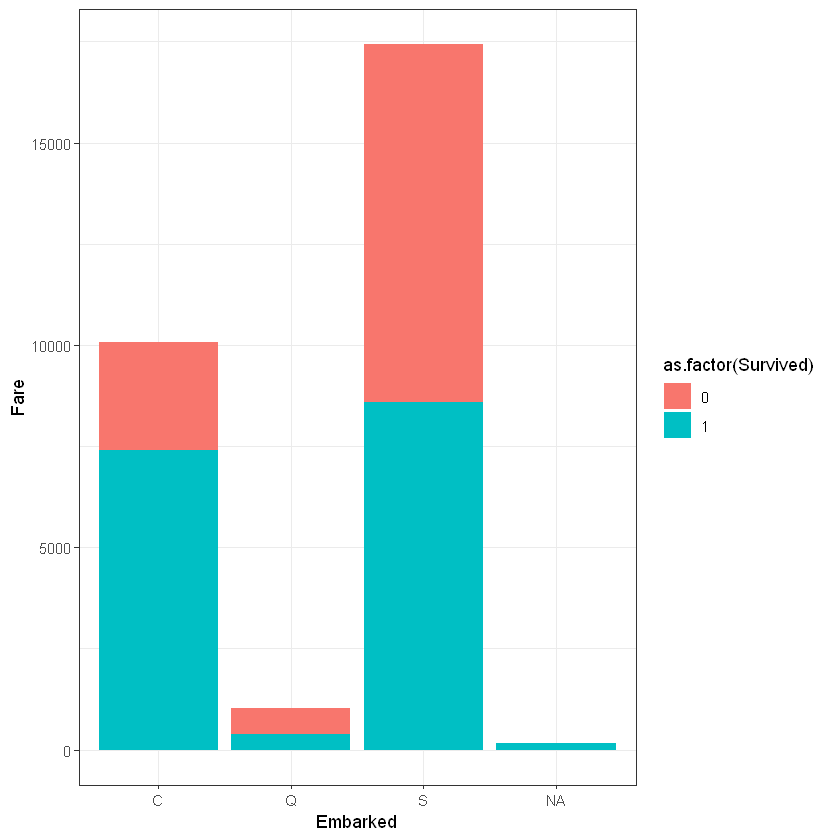

In [7]:
table(train$Survived)
correlation <- cor(train[,6:7]) # Somewhat +0.41 Correlated, possibly redundant info. 
correlation_fare_age <- cor(train[,c(5,9)])
corrplot(correlation_fare_age,method = "number") # 0.09 Practically Independent
corrplot(correlation,method = "number")
ggplot(train, mapping = aes(x = as.factor(Survived), y = Fare, fill = as.factor(Pclass))) + geom_bar(stat = "identity")
ggplot(train, mapping = aes(x = Age)) + geom_histogram(fill = "red") + geom_vline(aes(xintercept = mean(Age)),size = 2) + theme_bw()
ggplot(train, mapping = aes(x = Fare, fill = as.factor(Survived))) + geom_histogram() + theme_bw()
ggplot(train, mapping = aes(x = Pclass, y = Survived)) + geom_bar(stat = "identity",fill = "red") + theme_bw()
ggplot(train, mapping = aes(x = Age, y = Fare, color = as.factor(Survived))) + geom_point() + theme_bw()
ggplot(train, mapping = aes(x = Embarked, y = Fare)) + geom_boxplot(fill = "red") + theme_bw()
ggplot(train,mapping = aes(x = Embarked, y = Fare, fill = as.factor(Survived))) + geom_bar(stat = "identity") + theme_bw()

# Model Selection

We went ahead and selected the only features that might be useful to classify the survival of passengers.

Those following variables are: 
* 'Pclass'
* 'Embarked'
* 'Parch'
* 'Sex'
* 'SibSp'
* 'Age'

Finally, we employed Logistic Regression and applied the Stepwise Function to obtain the most parsimonious model. Additionally, we utilized Naive Bayes for our classification model suggests a naive independence between features, the Support Vector model with a radial kernel, considering that the correlation matrix indicated non-linear features. We also implemented a decision tree, revealing that if you are older than 6.5 years old and male, you have a 62% chance of perishing as a passenger. Conversely, if you are a female in a higher class aboard the Titanic, you have a 19% chance of survival. Lastly, we employed a random forest model.


Call:  glm(formula = Survived ~ Pclass + Embarked + Sex + SibSp + Age, 
    family = "binomial", data = logtrain)

Coefficients:
(Intercept)       Pclass    EmbarkedQ    EmbarkedS      Sexmale        SibSp  
    5.46959     -1.16358     -0.04398     -0.45136     -2.67524     -0.33715  
        Age  
   -0.04053  

Degrees of Freedom: 888 Total (i.e. Null);  882 Residual
  (2 observations deleted due to missingness)
Null Deviance:	    1183 
Residual Deviance: 784.6 	AIC: 798.6

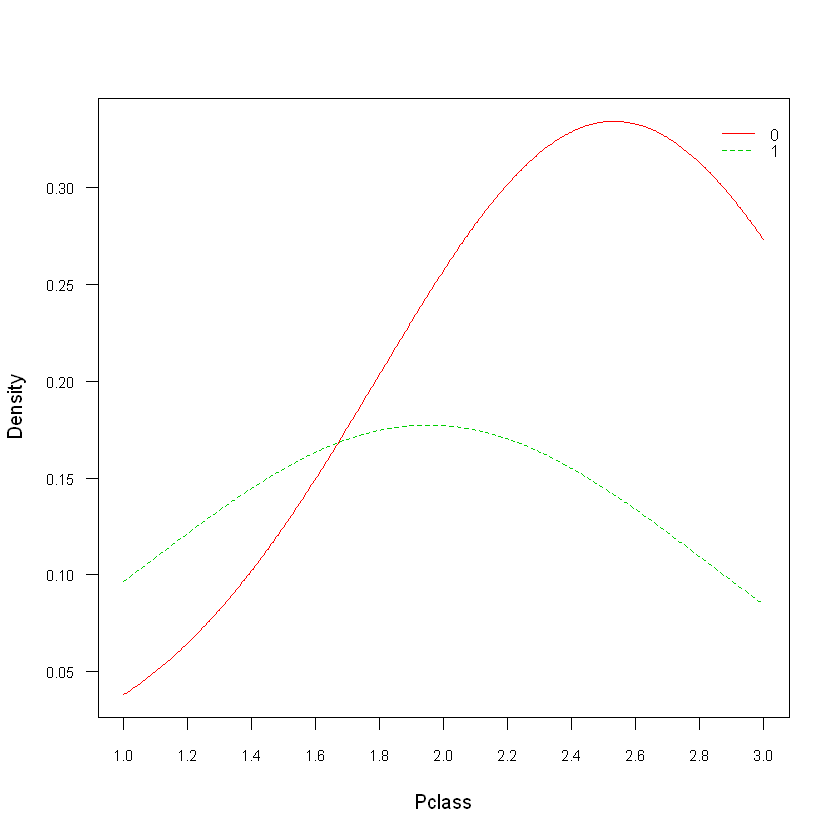

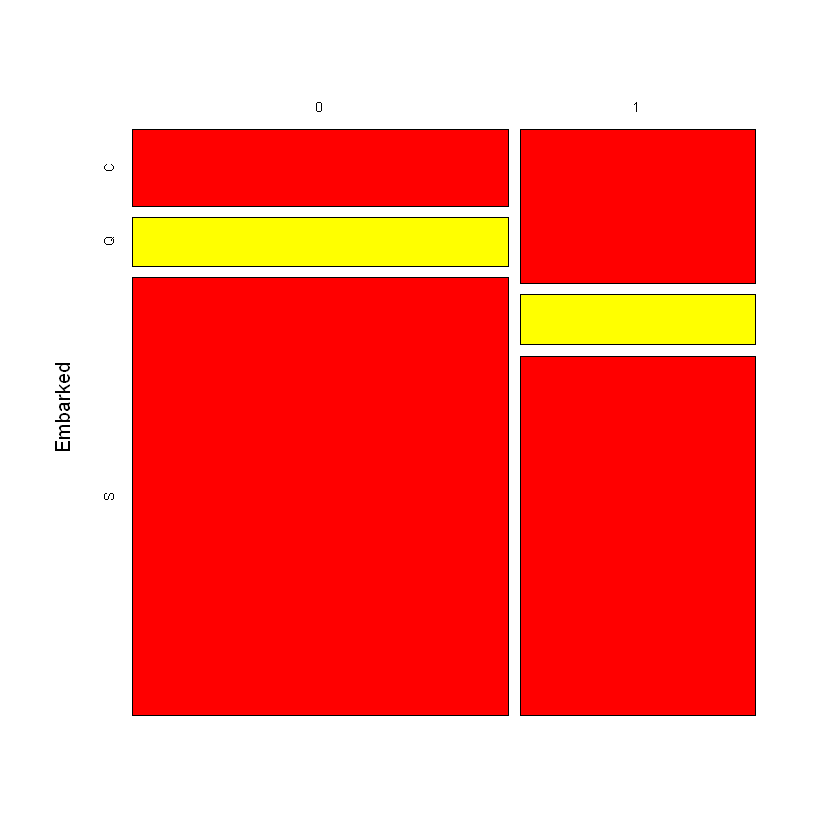

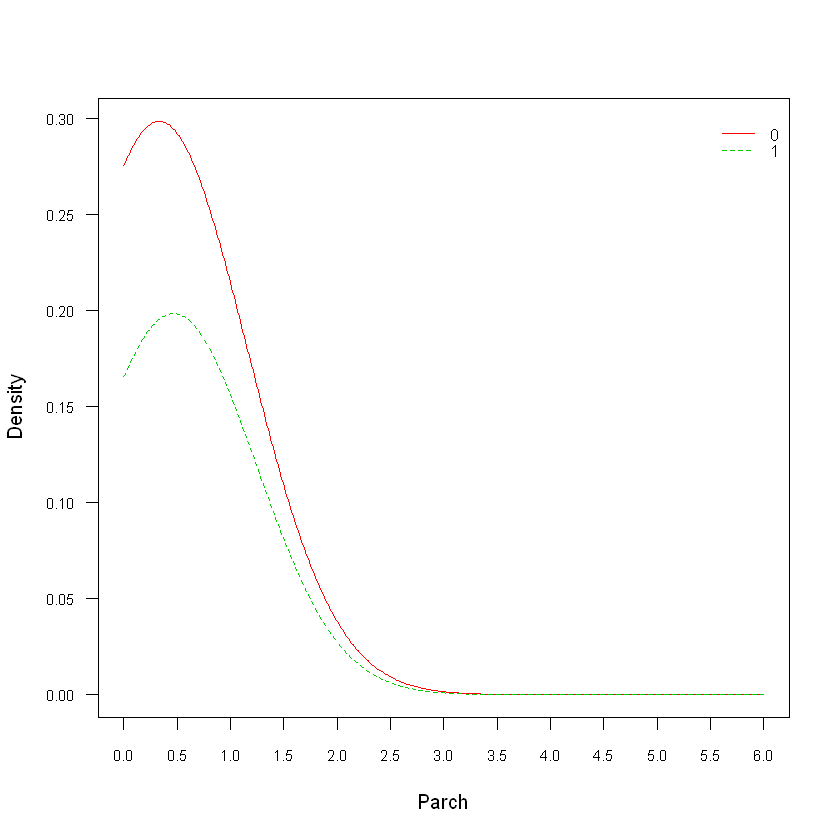

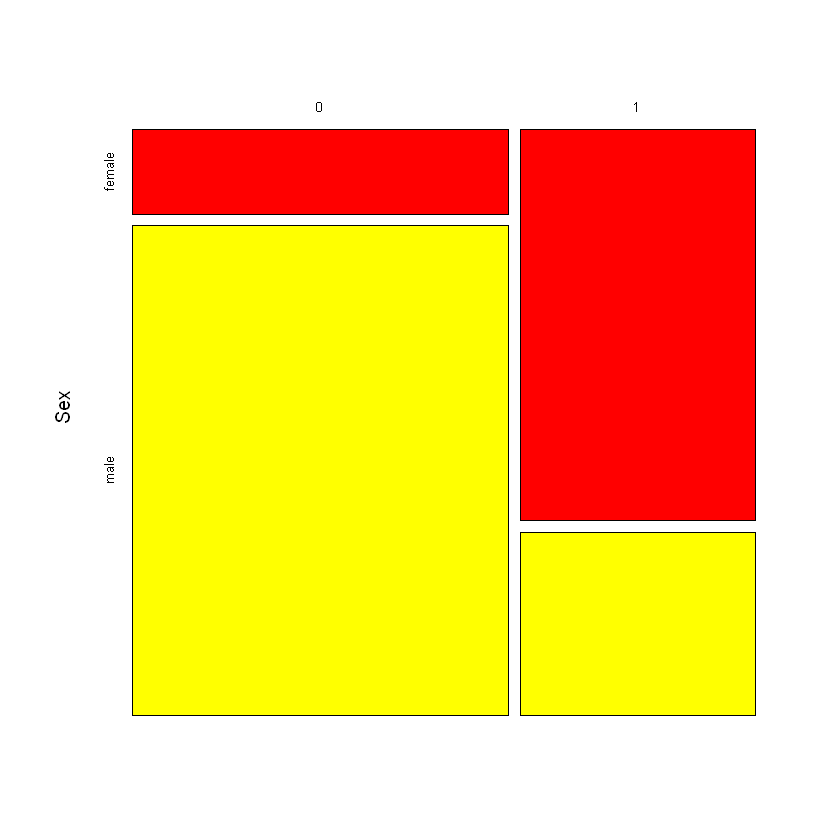

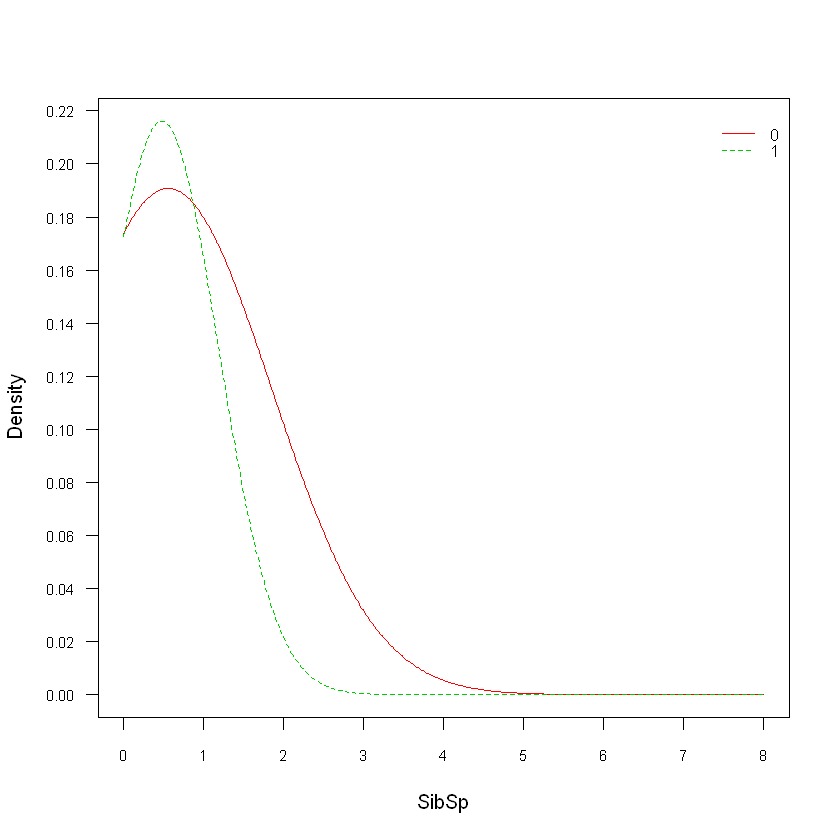


================================== Naive Bayes ================================== 
 
- Call: naive_bayes.formula(formula = as.factor(Survived) ~ ., data = logtrain) 
- Laplace: 0 
- Classes: 2 
- Samples: 891 
- Features: 6 
- Conditional distributions: 
    - Bernoulli: 1
    - Categorical: 1
    - Gaussian: 4
- Prior probabilities: 
    - 0: 0.6162
    - 1: 0.3838

--------------------------------------------------------------------------------- 


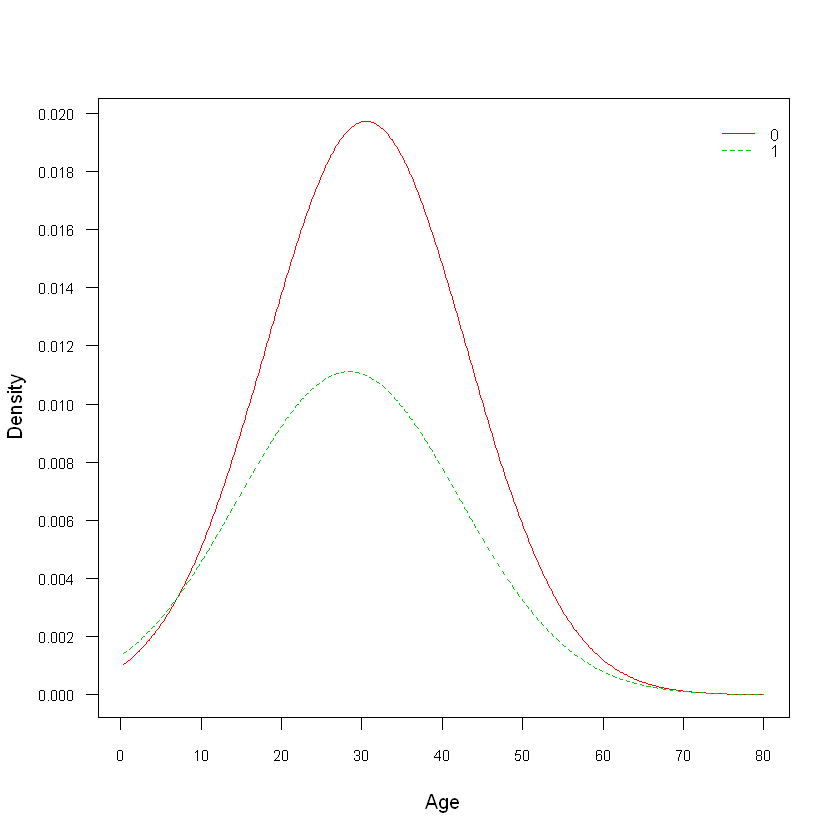


Call:
 randomForest(formula = as.factor(Survived) ~ ., data = logtrain,      ntree = 300, importance = T, mtry = sqrt(6), na.action = na.exclude) 
               Type of random forest: classification
                     Number of trees: 300
No. of variables tried at each split: 2

        OOB estimate of  error rate: 17.1%
Confusion matrix:
    0   1 class.error
0 506  43  0.07832423
1 109 231  0.32058824

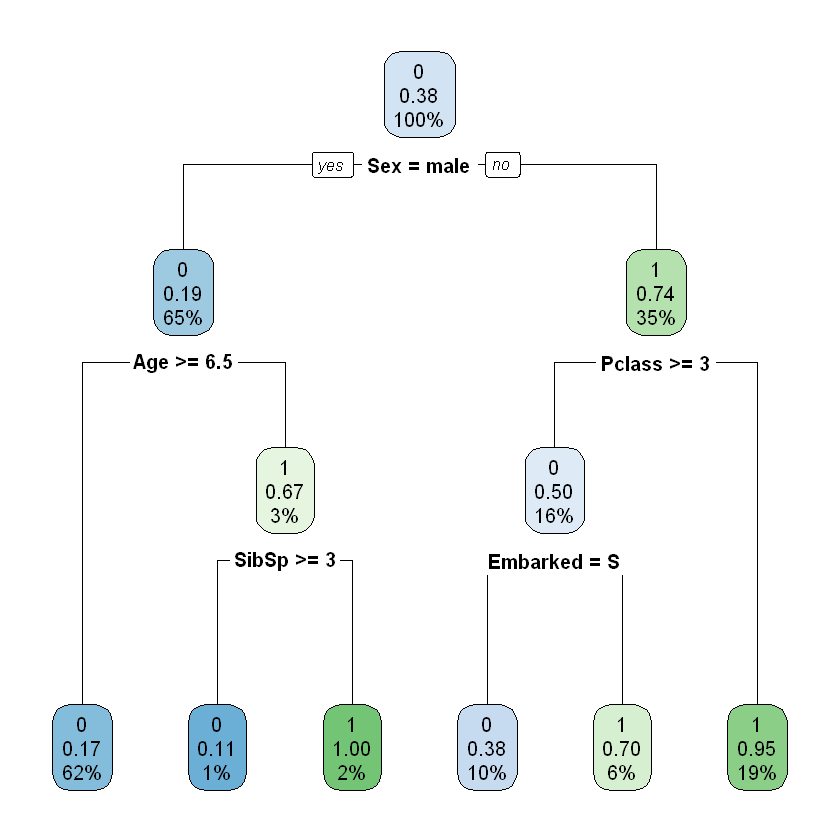

In [33]:

logtrain <- train %>% dplyr::select(Survived,Pclass,Embarked,Parch,Sex,SibSp,Age)
logtest <- test %>% dplyr::select(Pclass,Embarked,Parch,Sex,SibSp,Age)

### Logistic Regression Model
fullmodel <- glm(Survived ~ ., data = logtrain, family = "binomial")
stepmodel <- fullmodel %>% stepAIC(trace = F) # Use Stepwise alogrithim to get a Parsimony model. 
stepmodel # Parsimony

### Naive Bayes
Bayes_model <- naive_bayes(as.factor(Survived) ~ ., data = logtrain)
plot(Bayes_model)
summary(Bayes_model)

### SVM 
SVM_model <- svm(formula = as.factor(Survived) ~ ., data = logtrain, kernal = "radial") # Based on the correlation matrix, kernal != linear -> nonlinear, so radial

### Decision Tree
dec_model <- rpart::rpart(formula = as.factor(Survived) ~ .,data = logtrain, method = "class")
rpart.plot::rpart.plot(dec_model)

### Random Forest
rf_model <- randomForest(formula = as.factor(Survived) ~ ., data = logtrain,na.action = na.exclude,ntree = 300, importance = T,mtry = sqrt(6))
rf_model


# Model Evaluation

After computing the different models, we evaluate the accuracy rate of our models when compared to the actual outcome of the surviving passengers. The metric we are using is the confusion matrix.

* Logistic Regression: We have an accuracy of 94% with an 87% Kappa value. This suggests that we have a model that accurately measures specificity and Sensitivity. Furthermore, the 87% Kappa value suggests that the model is pretty good agreement as it accounts in case of a skewed distribution for our target distribution.
* Naive Bayes: We have an accuracy of 85% with a 70% Kappa value. This suggests that we have a model that accurately measures specificity and Sensitivity on a moderate level. Furthermore, the 70% Kappa value suggests that the model is in good agreement as it accounts for the case of a skewed distribution for our target distribution.
* Decision Tree: We have an accuracy of 89% with a 74% Kappa value. This suggests that we have a model that accurately measures specificity and Sensitivity. Furthermore, the 74% Kappa value suggests that the model is in good agreement as it accounts for the case of a skewed distribution for our target distribution.
* Random Forest: We have an accuracy of 89% with a 77% Kappa value. This suggests that we have a model that accurately measures specificity and Sensitivity. Furthermore, the 77% Kappa value suggests that the model is in good agreement as it accounts for the case of a skewed distribution for our target distribution.
    + We can see that the error rate decreases as we hit 50 trees and fluctuates up and down beyond 50.
    + We can observe that the Sex variable is an important feature when computing our model for the random forest model. 

In conclusion, we choose the logistic regression for our model selection. The next steps are to tune the model to maximize and get the optimal model as much possible.  

[[1]]
   my_predict_result
      0   1
  0 192  13
  1   8 119

[[2]]
[1] 0.936747

[[3]]
[1] 0.8670987


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 211   7
         1  55 145
                                          
               Accuracy : 0.8517          
                 95% CI : (0.8139, 0.8844)
    No Information Rate : 0.6364          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6998          
                                          
 Mcnemar's Test P-Value : 2.387e-09       
                                          
            Sensitivity : 0.7932          
            Specificity : 0.9539          
         Pos Pred Value : 0.9679          
         Neg Pred Value : 0.7250          
             Prevalence : 0.6364          
         Detection Rate : 0.5048          
   Detection Prevalence : 0.5215          
      Balanced Accuracy : 0.8736          
                                          
       'Positive' Class : 0               
                              

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 260  41
         1   6 111
                                          
               Accuracy : 0.8876          
                 95% CI : (0.8533, 0.9162)
    No Information Rate : 0.6364          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7444          
                                          
 Mcnemar's Test P-Value : 7.071e-07       
                                          
            Sensitivity : 0.9774          
            Specificity : 0.7303          
         Pos Pred Value : 0.8638          
         Neg Pred Value : 0.9487          
             Prevalence : 0.6364          
         Detection Rate : 0.6220          
   Detection Prevalence : 0.7201          
      Balanced Accuracy : 0.8539          
                                          
       'Positive' Class : 0               
                              

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 191  21
         1  14 106
                                          
               Accuracy : 0.8946          
                 95% CI : (0.8564, 0.9255)
    No Information Rate : 0.6175          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7745          
                                          
 Mcnemar's Test P-Value : 0.3105          
                                          
            Sensitivity : 0.9317          
            Specificity : 0.8346          
         Pos Pred Value : 0.9009          
         Neg Pred Value : 0.8833          
             Prevalence : 0.6175          
         Detection Rate : 0.5753          
   Detection Prevalence : 0.6386          
      Balanced Accuracy : 0.8832          
                                          
       'Positive' Class : 0               
                              

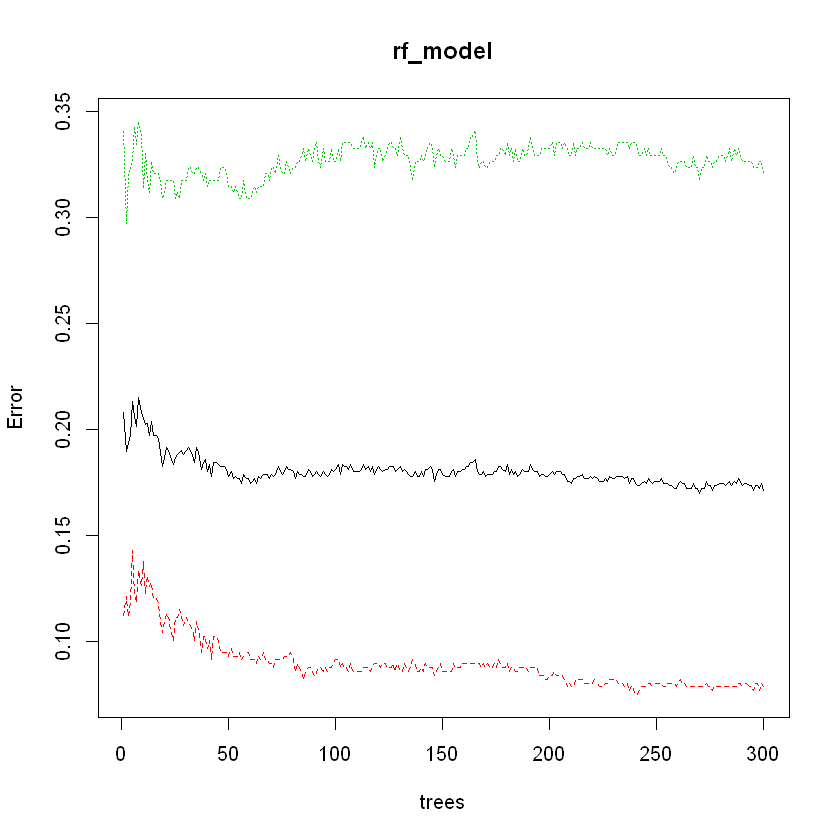

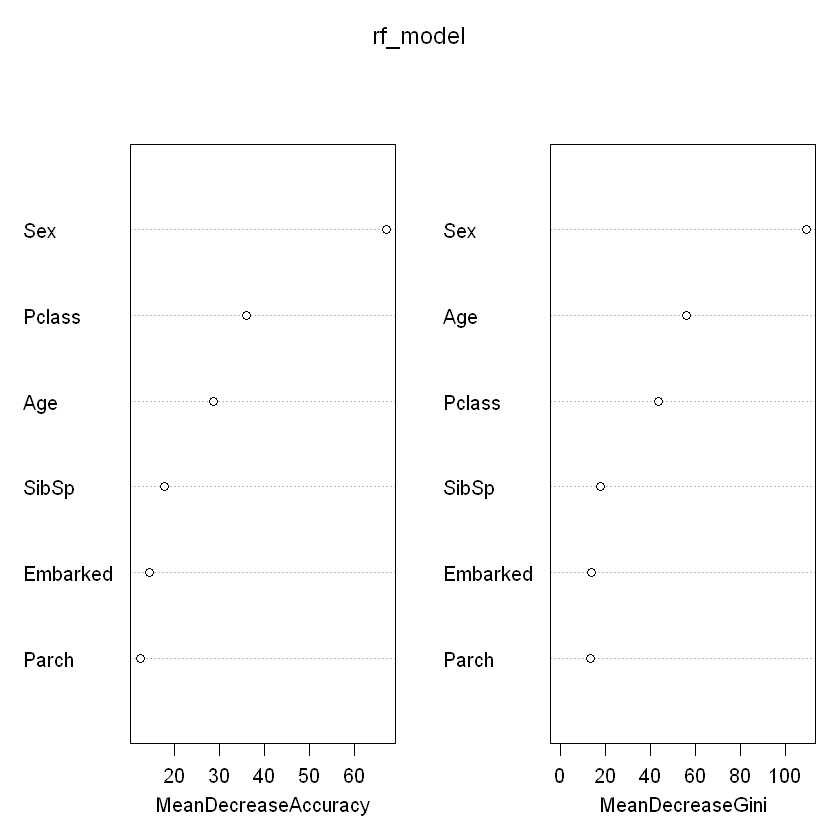

In [34]:
predict_foo <- function(model,test,class_type){
  if(class_type == "logistic"){
    result <- predict(model, test, type = "response")
    my_predict_result <- ifelse(result > 0.5,1,0)
    result_class_algo <- table(gender_submission$Survived,my_predict_result)
    accuracy <- (result_class_algo[1] + result_class_algo[4]) / sum(result_class_algo[1:4])
    p_correct <- ((result_class_algo[1] + result_class_algo[2]) / sum(result_class_algo[1:4])) * ((result_class_algo[1] + result_class_algo[3]) / sum(result_class_algo[1:4]))
    p_incorrect <- ((result_class_algo[3] + result_class_algo[4]) / sum(result_class_algo[1:4])) * ((result_class_algo[2] + result_class_algo[4]) / sum(result_class_algo[1:4]))
    p_e <- p_correct + p_incorrect
    kappa_value <- (accuracy - p_e) / (1-p_e)
    return(list(result_class_algo, accuracy, kappa_value))
  }else{
    my_predict_result <- predict(model,test,type = "class")
    more_result <- confusionMatrix(my_predict_result,as.factor(gender_submission$Survived))
    return(more_result)
  }
  
}

predict_foo(stepmodel,logtest,"logistic") # Logistic Confusion Matrix

predict_foo(Bayes_model,logtest,"Bayes") # Bayes Confusion Matri

predict_foo(dec_model,logtest,"DEC") # Decision Tree Confusion Matrix

predict_foo(rf_model,logtest,"RF") # Random Forest Tree Confusion Matrix
plot(rf_model)
varImpPlot(rf_model)
